# Testing a general data reader for AQUA 
## (working on Levante for now)

The idea of this AQUA reader draft is to provide a first common access point to data in order to quickly develop diagnostics. For now access is through intake catalogues of NextGEMS data, but the idea is to extend this to FDB access and other datasources in the future.

It includes also regridding functionality. The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation.

For all this to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module.

In [1]:
from aqua import Reader
from aqua.reader import catalogue

In [18]:
from dask.distributed import Client
import dask
import numcodecs
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})



Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


KeyError: 'JUPYTERHUB_SERVICE_PREFIX'

<Client: 'inproc://136.172.124.7/4104597/17' processes=1 threads=256, memory=59.60 GiB>

In [5]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

In [6]:
cluster = SLURMCluster(name='dask-cluster',
                      cores=1,
                      memory='256GB',
                      processes=1,
                      interface='ib0',
                      queue='compute',
                      project='bb1153',
                      walltime='12:00:00',
                      asynchronous=0)

/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/dask_jobqueue/slurm.py:49: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [12]:
client.shutdown()

/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/dask_jobqueue/slurm.py:49: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [13]:
cluster.close()

In [7]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://136.172.124.7:8787/status,
Dashboard: http://136.172.124.7:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://136.172.124.7:35527,Workers: 0
Dashboard: http://136.172.124.7:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
cluster.scale(16)

/home/b/b382075/mambaforge/envs/aqua/lib/python3.9/site-packages/dask_jobqueue/slurm.py:49: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Optional: open a cluster client to parallelize dask

In [1]:
from dask.distributed import Client
import dask
import numcodecs
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

processes = False
nworker = 16
ncpu = 16
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")

client = Client(n_workers=nworker, threads_per_worker=threads, memory_limit='12GB')


2023-02-02 12:04:45,377 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-dl_loyxw', purging
2023-02-02 12:04:45,377 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-fqfst1lw', purging
2023-02-02 12:04:45,377 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-lfmdhg21', purging
2023-02-02 12:04:45,377 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-547qyr0w', purging
2023-02-02 12:04:45,377 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-a0y6j6_5', purging
2023-02-02 12:04:45,378 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-250225/worker-5q921y5l', purging
2023-02-02 12:04:45,378 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/d

In [12]:
# client.shutdown()
# cluster.close()

First let's see what is available (this function also returns the intake catalogue, that's why we use a semicolon)

In [2]:
catalogue();

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
	- interpolated_sp_ci	
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	

FESOM	tco3999-ng5	2.5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- np	nearest-neighbor interpolation to lat-lon grid
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	original 2d output
	- original_3d	original 3d output
FESOM	tco2559-ng5	5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	orig

## Example 1: IFS

Now let's load some IFS data

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d")
data = reader.retrieve()

In [7]:
data.coords

Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01

These are raw IFS data on the original grid

In [13]:
data.rename({"lat": "latitude"})

<xarray.Dataset>
Dimensions:   (time: 8329, value: 26306560, level: 5)
Coordinates:
    latitude  (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level     (level) int64 1 2 3 4 5
    lon       (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2020-01-20 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...        ...
    uvb       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z         (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [23]:
from metpy.units import units
def convert_units(src, dst):
    usrc = units(src).to_base_units()
    udst = units(dst).to_base_units()
    fac = usrc / udst
    if fac.units != "dimensionless":
        if fac.units == "meter ** 3 / kilogram":
            fac = fac * 1000 * units("kg m-3")
    return fac
    



In [27]:
a=convert_units("mm month-1", "kg/m2/s")

2629800.0 <Unit('dimensionless')>

In [1]:
from metpy.units import units

In [13]:
usrc=units("degC").to_base_units()
udst=units("K").to_base_units()

In [17]:
udst/usrc

0.0036476381542950944 <Unit('dimensionless')>

Let's try again, this time specifying that we want to regrid to a specific regular grid (0.2 deg in this case)

In [1]:
from aqua import Reader
from aqua.reader import catalogue

reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid="r020")
data = reader.retrieve()


tp: corrected multiplying by density of water 1000 kg m-3
tp: corrected dividing by accumulation time 10800 s


In [2]:
data.pr

<xarray.DataArray 'pr' (time: 8329, value: 26306560)>
dask.array<open_dataset-944843a8674ddf5cb201907ea537da85tp, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/17)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    target_units:               kg m-2 s-1
    factor:                     0.09259259259259259

In [32]:
data.keys()

KeysView(<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, va

In [62]:
fixes = load_yaml("config/fixes.yaml")

ScannerError: mapping values are not allowed here
  in "config/fixes.yaml", line 2, column 9

In [49]:
fixes

{'IFS': {'vars': {'2t': {'short_name': 'tas', 'units': 'K'},
   'tp': {'short_name': 'pr', 'units': 'Kg m-1 s-1'}}}}

In [66]:
"pip" in data.variables

False

In [ ]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid="r020")
data = reader.retrieve()

In [29]:
from aqua.util import load_yaml
fixes = load_yaml("config/fixes.yaml")
model="IFS"
fixd = {}
attd = {}
fix = fixes["models"][model]

allvars = data.variables
for var in fix["vars"]:
            shortname = fix["vars"][var]["short_name"]
            if var in allvars: 
                fixd.update({f"{var}": f"{shortname}"})
                data[var].attrs.update({"factor": fix["vars"][var]["factor"]})
                units = fix["vars"][var]["units"]
                if units.count('{'):
                    units = fixes["defaults"]["units"][units.replace('{','').replace('}','')]                
                data[var].attrs.update({"target_units": units})

allcoords = data.coords
for coord in fix["coords"]:
            print(fix["coords"][coord])
            newcoord = fix["coords"][coord]["name"]
            if coord in allcoords: 
                fixd.update({f"{coord}": f"{newcoord}"})

data2=data.rename(fixd)

K
{precipitation}
{'name': 'latitude'}


In [24]:
data2["pr"]

<xarray.DataArray 'pr' (time: 8329, value: 26306560)>
dask.array<open_dataset-944843a8674ddf5cb201907ea537da85tp, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    latitude  (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon       (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2020-01-20 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/17)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    factor:                     1000
    target_units:               kg m-1 s-1

again, by deafault, the data are still on the raw original grid

In [35]:
offset = (0*units("degC")).to_base_units() - (0*units("K")).to_base_units()
factor = (units("degC")).to_base_units() / (units("K")).to_base_units() 
factor

274.15 <Unit('dimensionless')>

In [55]:
src="mm/h"
dst="m/s"
fac = units(src).to_base_units() / units(dst).to_base_units()
off = ((0 * units(src)) - (0 * units(dst))).to(units(dst))
if off.magnitude != 0:
    fac = None
    off = off.magnitude
else:
    off = None
    fac = fac.magnitude
print(fac, off)


2.777777777777778e-07 None


... but we can now ask to regrid it (or parto of it) to the destination grid which we chose when we instantiated the reader.

In [16]:
tasr = reader.regrid(data["2t"][0:100,:])

In [18]:
tasr.rename({"lat": "latitude", "lon": "longitude" })

<xarray.DataArray '2t' (time: 100, latitude: 900, longitude: 1800)>
dask.array<reshape, shape=(100, 900, 1800), dtype=float64, chunksize=(1, 900, 1800), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-01-20 ... 2020-01-24T03:00:00
  * latitude   (latitude) float64 -89.9 -89.7 -89.5 -89.3 ... 89.5 89.7 89.9
  * longitude  (longitude) float64 0.0 0.2 0.4 0.6 ... 359.2 359.4 359.6 359.8

In [4]:
tasr.mean("time").plot()

: 

: 

Notice: You could ask to regrid them directly by specifying the argument `regrid=True` when reading the data, but please be warned that without a selection on dates this will take longer. It is usuallymore efficient to first load the data, select and then regrid. The option `regrid=True` for the reader will make sense probably for streamed data, if you know that you will want to regrid all of the input xarray anyway. The regridding is applied to a dask dataarray, so execution is delayed and one can select variables and periods of interest later, but still, it takes longer by asking to regrid everything at this stage. To be tested further.

## Example 2: ICON

Instantiate a reader for ICON data specifying that we will want to interpolate to a 1 deg grid (the grids are defined in the regrid.yaml file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [19]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r100")

Load the actual data. By default these data have not been regridded yet. 

You could ask to regrid them directly by specifying the argument `regrid=True` but please be warned that without a selection on dates this will take longer. It is usuallymore efficient to first load the data, select and then regrid.

In [20]:
data = reader.retrieve()

By default these data have not been regridded yet

In [29]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/34)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    clivi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cllvi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfls      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfss      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    tas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauu      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauv      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ts        (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    uas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    vas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 152214
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Now we actually regrid part of the data (the first 400 frames)

In [21]:
tasr = reader.regrid(data.tas[0:400,:]) 

In [22]:
tasr

<xarray.DataArray 'tas' (time: 400, lat: 180, lon: 360)>
dask.array<reshape, shape=(400, 180, 360), dtype=float64, chunksize=(6, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 ... 2020-01-28T07:30:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

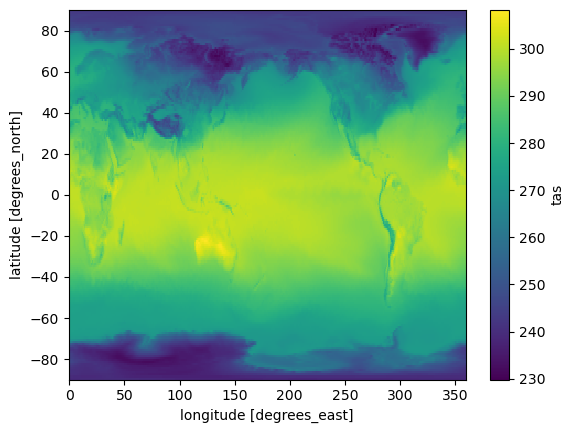

In [7]:
tasr.mean("time").plot()

In [33]:
tasr.to_netcdf("test.nc")

## Example 3: Healpix data (ICON)

We can also read healpix data. Healpix implements the `zoom` parameter. `zoom=9` (default) is 12.5 Km, every lower number halves resolution. 

In [11]:
reader = Reader(model="ICON", exp="hpx", zoom=9)
data = reader.retrieve()

In [6]:
data

<xarray.Dataset>
Dimensions:             (time: 8640, pix: 3145728, level: 90)
Coordinates:
  * level               (level) float64 nan 1.0 2.0 3.0 ... 86.0 87.0 88.0 89.0
  * time                (time) datetime64[ns] 2020-07-23T00:30:00 ... 2021-01-19
Dimensions without coordinates: pix
Data variables:
    10m_wind_speed      (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    cli                 (time, level, pix) float32 dask.array<chunksize=(1, 10, 262144), meta=np.ndarray>
    clivi               (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    cllvi               (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clw                 (time, level, pix) float32 dask.array<chunksize=(1, 10, 262144), meta=np.ndarray>
    sea_level_pressure  (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    tas                 (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>

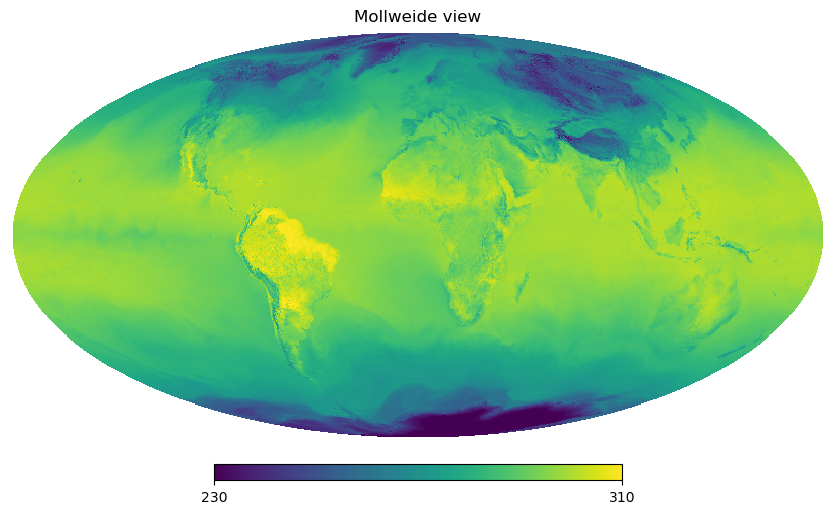

In [8]:
import healpy
healpy.visufunc.mollview(
    data.tas.sel(time="2020-11-02T19:00:00").values,
    nest=True, flip="geo", min=230, max=310)

## Example 4: FESOM data (interpolated)

In [2]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="interpolated_global_TS")
data = reader.retrieve()

ValueError: the new name 'lat' conflicts

In [12]:
data.salt.attrs.update({"units": "degC"})

In [13]:
data.salt.units

'degC'

In [3]:
t = data.temp.isel(time=0).isel(depth=0)

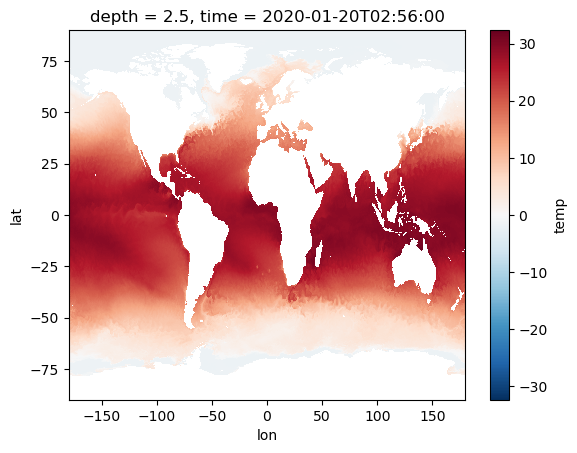

In [5]:
t.plot()

## MSWEP precipitation data

In [7]:
reader = Reader(model="MSWEP", exp="past", source="monthly")

In [8]:
data = reader.retrieve()

In [10]:
data.precipitation.units

'mm month-1'

In [11]:
from metpy.units import units

In [20]:
b=units("kg m-2 s-1")

In [21]:
b

1.0 <Unit('kilogram / meter ** 2 / second')>

In [32]:
(units(data.precipitation.units) / units("kg m-1 s-1")).to_base_units()

3.802570537683474e-10 <Unit('meter ** 2 / kilogram')>

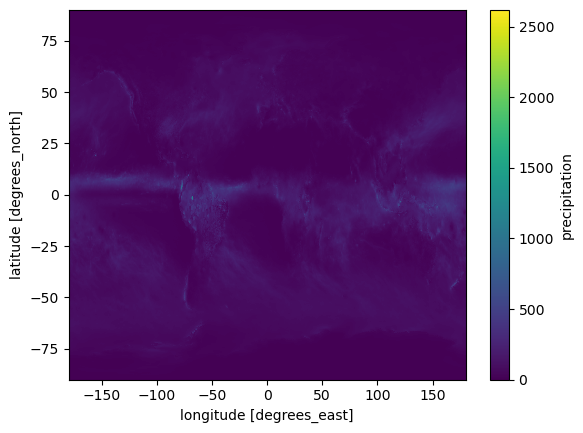

In [8]:
data.precipitation.isel(time=[0,1,2,3]).mean("time").plot()